<a href="https://colab.research.google.com/github/floflokie/SSL/blob/main/TP_Explicabilit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

# TP

### **Étape 1 : Préparation de l'environnement**

1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.

In [1]:
%%capture
!pip install lime
!pip install shap
!pip install torch torchvision
!pip install matplotlib

In [ ]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import lime
from lime import lime_image
import shap
from torch.utils.data import DataLoader
import torch.nn.functional as F
from skimage import segmentation, color

2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)), #input size for resnet18
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

classes = dataset.classes

100%|██████████| 169M/169M [00:02<00:00, 77.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


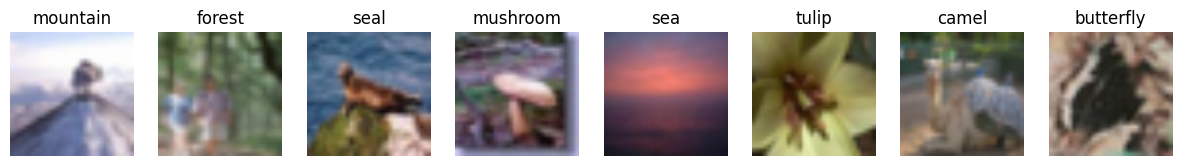

In [ ]:
def denormalize(image, mean, std):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

def show_images(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, label) in enumerate(zip(images, labels)):
        image = denormalize(image, mean=mean, std=std)
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

images, labels = next(iter(dataloader))
images = images[:8]
labels = labels[:8]

show_images(images, labels, classes)

### **Étape 2 : Charger un modèle pré-entraîné**


1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# change to 100 classes for Cifar100
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model.to(device)
model.eval()
print("Model loaded")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.9MB/s]


Model loaded


2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  

In [ ]:
def predict(model, images, classes, device):
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        conf, classes_pred = torch.max(probs, dim=1)
        return conf, [classes[i] for i in classes_pred]


# predict for the only one batch of the test loader
preds = []
for images, labels in test_loader:
    preds += predict(model, images, classes, device)
    break

print("Predictions on the test set:")
for i in range(len(preds[0])):
    print(f"{preds[1][i]}: {preds[0][i]}")

Predictions on the test set:
woman: 0.040669996291399
aquarium_fish: 0.0352618470788002
woman: 0.05052701756358147
chimpanzee: 0.03802863508462906
squirrel: 0.02159205451607704
tank: 0.03382880985736847
chimpanzee: 0.035473670810461044
chimpanzee: 0.03139030188322067
aquarium_fish: 0.025774812325835228
bus: 0.05393044650554657
chimpanzee: 0.02979246899485588
chimpanzee: 0.06458330154418945
bear: 0.03598193824291229
aquarium_fish: 0.028534630313515663
leopard: 0.048672035336494446
aquarium_fish: 0.08506588637828827
chimpanzee: 0.034227948635816574
aquarium_fish: 0.03220061585307121
bear: 0.03760980814695358
woman: 0.07518595457077026
woman: 0.08706893026828766
chimpanzee: 0.041776370257139206
aquarium_fish: 0.034231167286634445
chimpanzee: 0.04774025082588196
chimpanzee: 0.04341540113091469
aquarium_fish: 0.04941108822822571
aquarium_fish: 0.03398805484175682
aquarium_fish: 0.03294404596090317
bus: 0.027849936857819557
leopard: 0.05515921860933304
leopard: 0.0669914111495018
woman: 0.07

3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

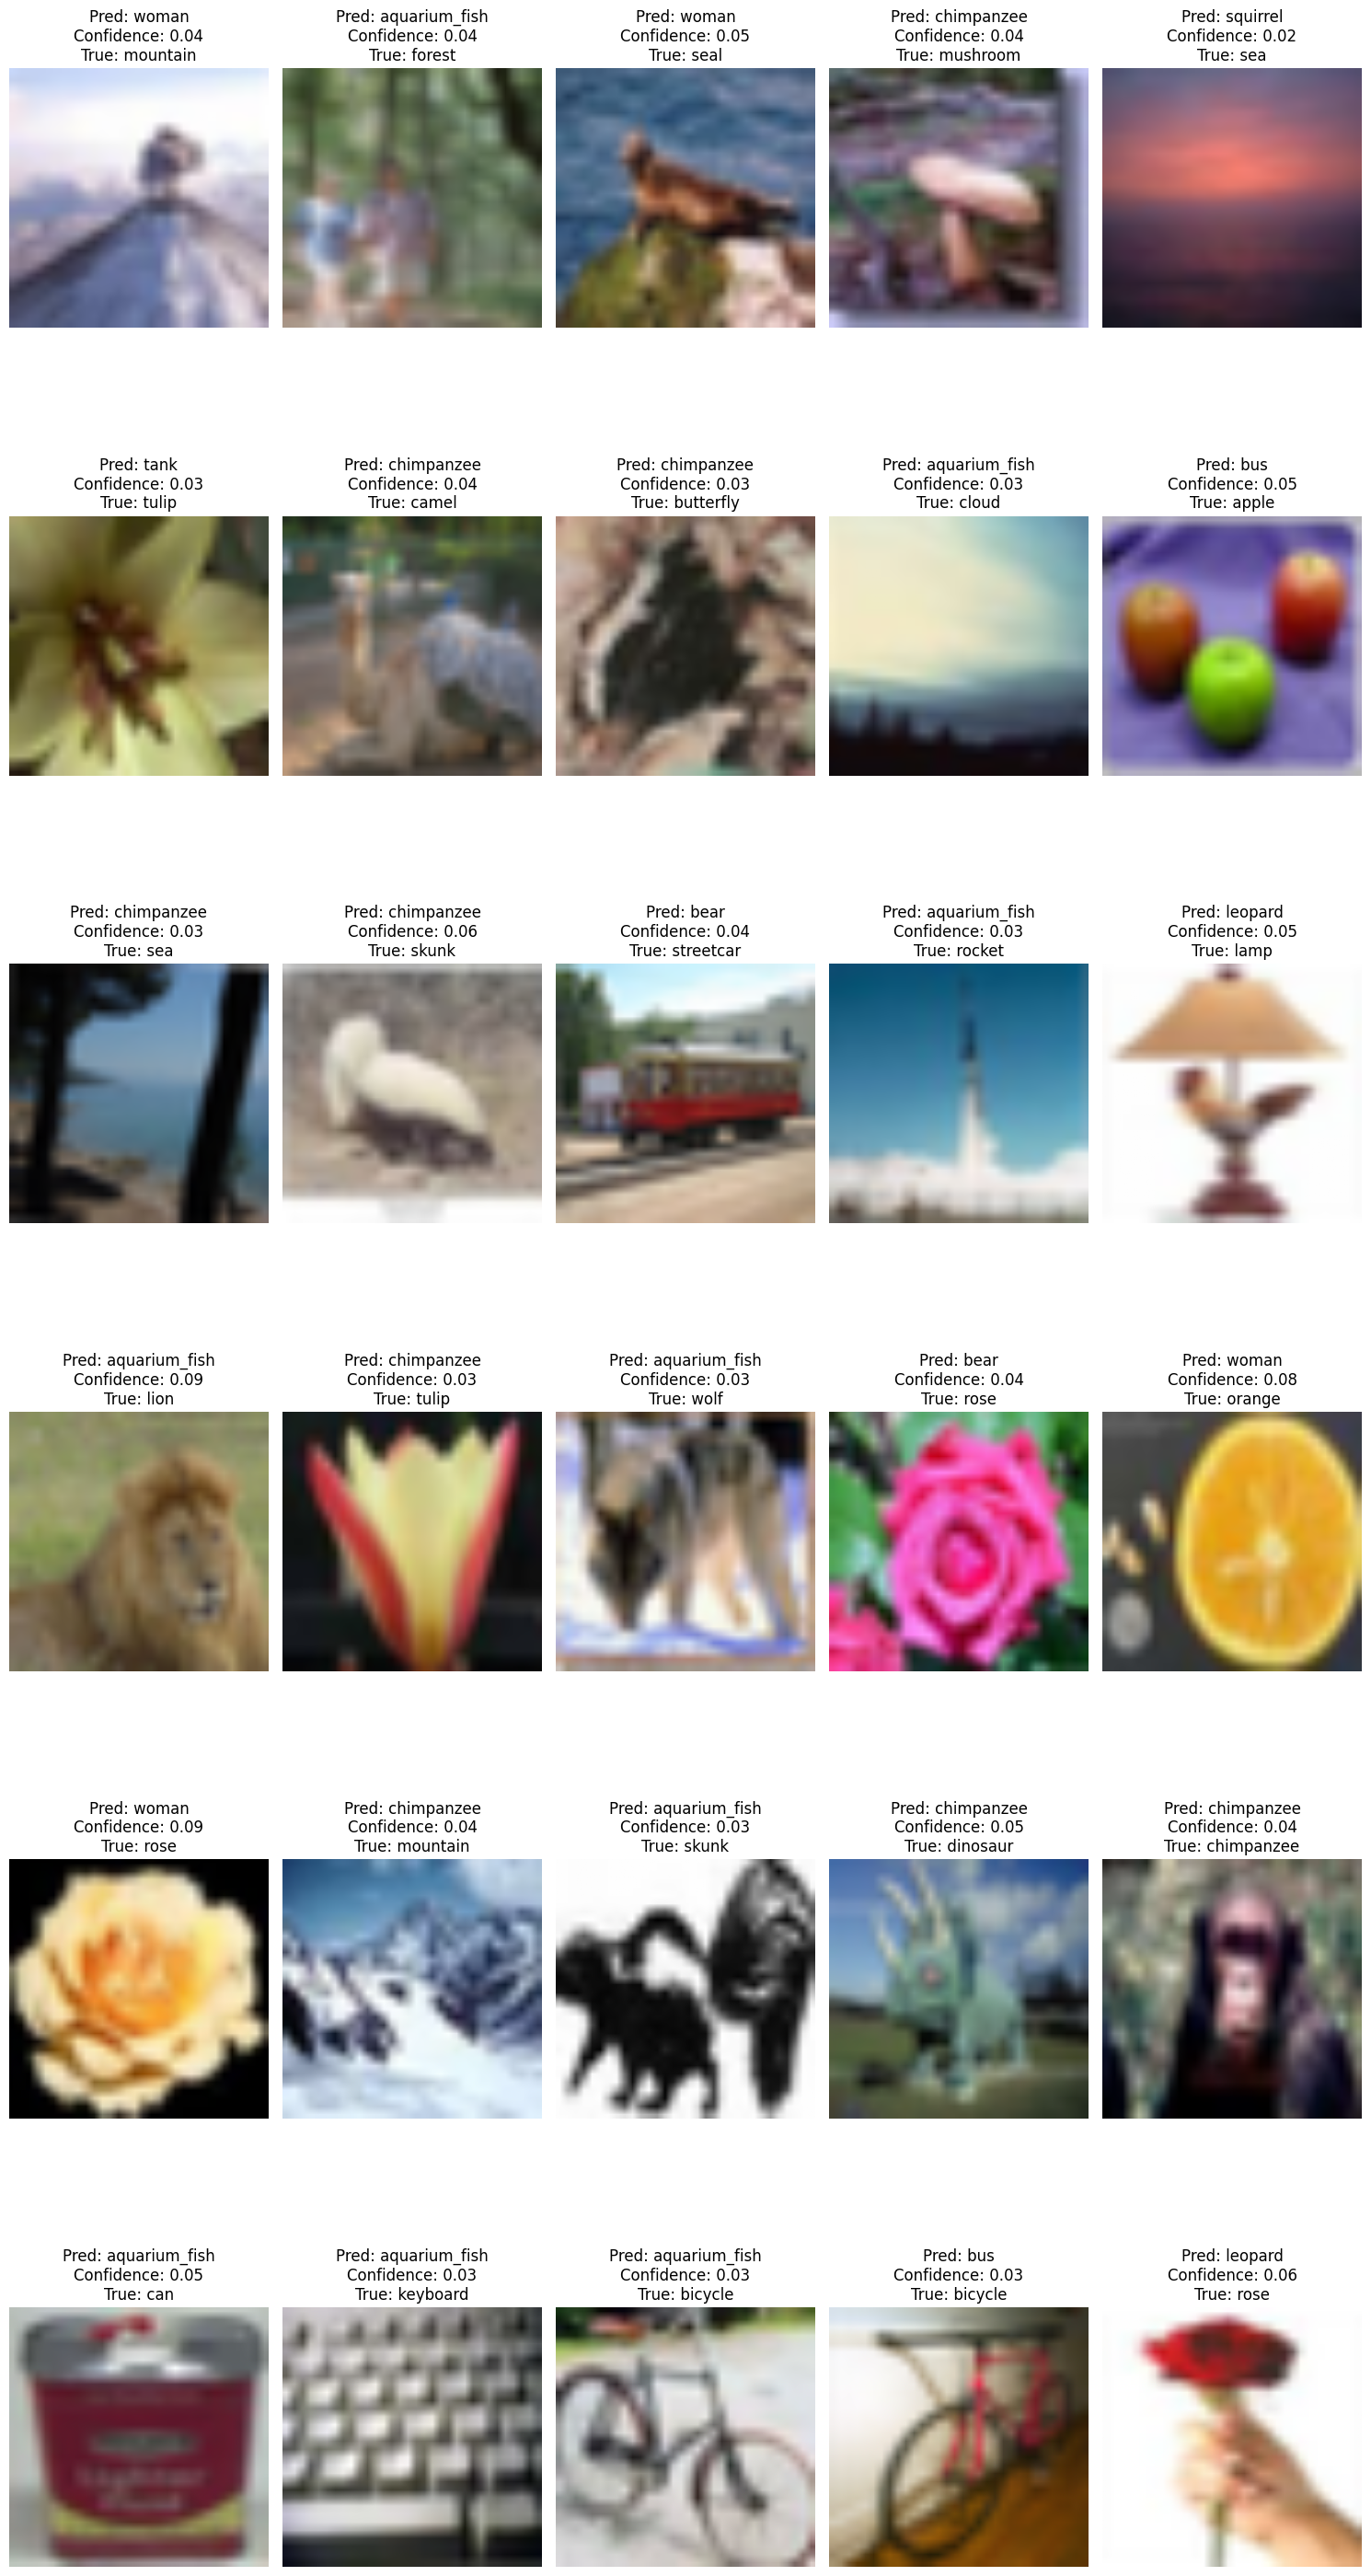

In [ ]:
def show_prediction(preds, images, labels, classes, model):
  confidences, preds = predict(model, images, classes, device)
  fig, axes = plt.subplots(len(images) // 5, 5, figsize=(15, 5 * (len(images) // 5)))
  axes = axes.flatten()
  for i, (image, pred, confidence, ax, true) in enumerate(zip(images, preds, confidences, axes, labels)):
    image = denormalize(image, mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Pred: {pred}\nConfidence: {confidence:.2f}\nTrue: {classes[true]}")
    ax.axis('off')
  plt.tight_layout()
  plt.show()

show_prediction(preds, images, labels, classes, model)

### **Étape 3 : Explicabilité avec LIME**

1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.

In [ ]:
explainer = lime_image.LimeImageExplainer()

2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  

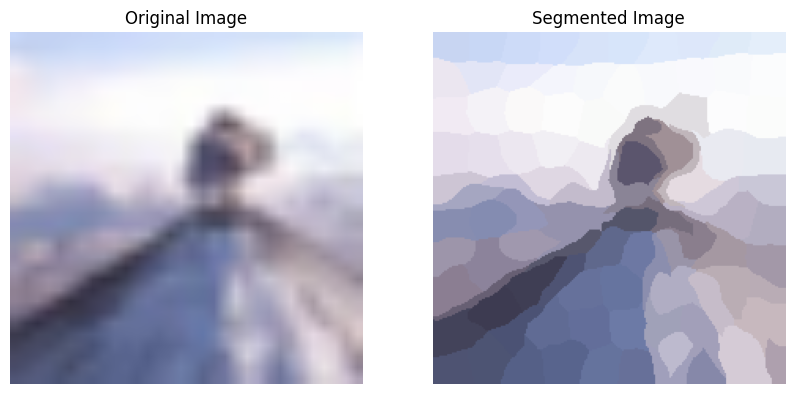

In [ ]:
def segment_image(image, num_segments=100):
    segments = segmentation.slic(image, n_segments=num_segments)
    return segments

image_segmented = segment_image(images[0].permute(1, 2, 0).numpy())

# show original and segmented
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(images[0].permute(1, 2, 0))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(color.label2rgb(image_segmented, images[0].permute(1, 2, 0).numpy(), kind='avg'))
axes[1].set_title("Segmented Image")
axes[1].axis('off')

plt.show()

In [ ]:
def predict_one_image(image, model=model, device=device):
  with torch.no_grad():
    image = torch.from_numpy(image.transpose((0, 3, 1, 2))).float()
    image = image.to(device)
    output = model(image)
    probs = F.softmax(output, dim=1)
    return probs.detach().cpu().numpy()

# get one image from the test
image = test_dataset[0][0].permute(1, 2, 0).numpy()
explanation = explainer.explain_instance(image, predict_one_image, top_labels=1, num_samples=1000, hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

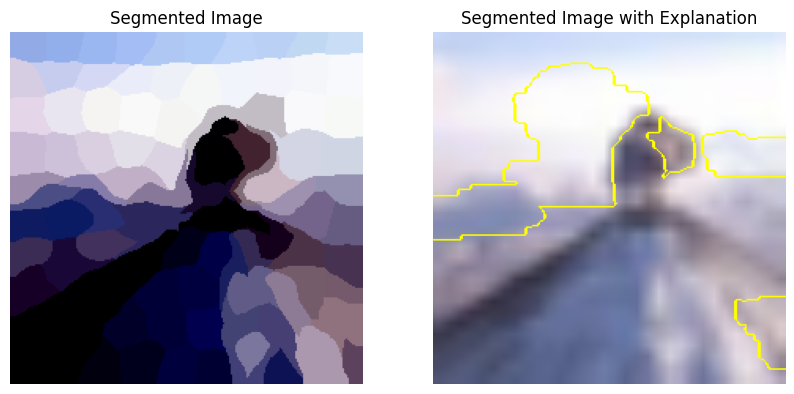

In [ ]:
def show_explanation(image, explanation):
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(color.label2rgb(segment_image(image), image, kind='avg'))
  axes[0].set_title("Segmented Image")
  axes[0].axis('off')
  axes[1].imshow(segmentation.mark_boundaries(temp / 2 + 0.5, mask))
  axes[1].set_title("Segmented Image with Explanation")
  axes[1].axis('off')
  plt.show()

show_explanation(image, explanation)


3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.


### **Étape 4 : Explicabilité avec SHAP**


1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  


2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  


In [ ]:
explainer_shap = shap.DeepExplainer(model, images.to(device))

3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.